In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import fixed_quad

# Constants
eV = 1.5192678e15
c_ms = 299792458
nm = 1e-9

In [2]:
#Calculate dielectric
def get_eps(w, med):
    # Parameters
    eb = 1
    wp = 12.04 * eV  # plasma frequency
    g = 0.1287 * eV  # gamma
    
    if med == 1:
        eps = 1.0
    elif med == 2:
        eps = eb - wp**2 / (w**2 + 1j * w * g)
    elif med == 3:
        eps = 1.0
    else:
        eps = None  # to improve a value med not recognized

    return eps

In [3]:
print("medium 1: ", get_eps(2*eV, 1))
print("medium 2: ", get_eps(2*eV, 2))
print("medium 3: ", get_eps(2*eV, 3))

medium 1:  1.0
medium 2:  (-35.0909501723848+2.3224526435929618j)
medium 3:  1.0


In [5]:
#Calculate reflection coefficient
def rij(w, kp, epsi, epsj, pol):
    # speed light
    k = w / c_ms
    
    # kz components
    kzi = np.sqrt(epsi * k**2 - kp**2 + 0j)
    kzj = np.sqrt(epsj * k**2 - kp**2 + 0j)
    
    # polarization
    if pol == 0:
        val = (kzi - kzj) / (kzi + kzj)
    elif pol == 1:
        val = (epsj * kzi - epsi * kzj) / (epsj * kzi + epsi * kzj)
    
    return val

In [6]:
w = 2 * eV
r120 = rij(w, 0, get_eps(w, 1), get_eps(w, 2), 0)
r121 = rij(w, 0, get_eps(w, 1), get_eps(w, 2), 1)
print("polarization 0: ",r120)
print("polarization 1: ",r121)

polarization 0:  (-0.9345768219268913-0.32423803713710425j)
polarization 1:  (0.9345768219268913+0.32423803713710425j)


In [7]:
def rT(w, kp, eps1, eps2, eps3, t, pol):
    k = w / c_ms
    kz2 = np.sqrt(eps2 * k**2 - kp**2 + 0j)
    expid = np.exp(2 * 1j * kz2 * t)
    
    r12 = rij(w, kp, eps1, eps2, pol)
    r23 = rij(w, kp, eps2, eps3, pol)
    
    val = (r12 + r23 * expid) / (1 - r12 * r23 * expid)
    return val

In [8]:
from scipy.integrate import quad

def get_G(w, t, z, kp_max, maxi):
    k = w / c_ms
    imG0= 2/3*k**3
    eps1 = get_eps(w, 1)
    eps2 = get_eps(w, 2)
    eps3 = get_eps(w, 3)

    # Define the integrand fxx
    def fxx(kp):
        kz = np.sqrt(eps1 * k**2 - kp**2 + 0j)
        expiz = np.exp(2 * 1j * kz * z)
        
        if kp == np.sqrt(eps1)*k:
            fxxv = 0
        else: 
        #Calculate fxxv
         fxxv = 1j / 2 * kp * expiz / kz * (
            (rT(w, kp, eps1, eps2,eps3 , t , 0) * k**2) - (rT(w, kp, eps1, eps2, eps3, t, 1) * kz**2)
        )
        #  fxxv = 1
        return fxxv
    
    def fzz(kp):
        kz = np.sqrt(eps1 * k**2 - kp**2 + 0j)
        expiz = np.exp(2 * 1j * kz * z)
        
        if kp == np.sqrt(eps1)*k:
            fxxv = 0
        else: 
        # Calculate fxxv
         fxxv = 1j * kp**3 * expiz / kz * (
            rT(w, kp, eps1, eps2, eps3, t, 1) 
        )
        #  fxxv = 1
        return fxxv
    
    Gxx_real, error_real = quad(lambda kp: np.real(fxx(kp)), 0, kp_max, limit=maxi)
    Gxx_imag, error_imag = quad(lambda kp: np.imag(fxx(kp)), 0, kp_max, limit=maxi)

    Gzz_real, error_real = quad(lambda kp: np.real(fzz(kp)), 0, kp_max, limit=maxi)
    Gzz_imag, error_imag = quad(lambda kp: np.imag(fzz(kp)), 0, kp_max, limit=maxi)
    
    return Gxx_real/imG0,Gxx_imag/imG0, Gzz_real/imG0, Gzz_imag/imG0
    #return Gxx_real,Gxx_imag, Gzz_real, Gzz_imag

# Example:
Gxx = get_G(2 * eV, 20 * nm, 5 * nm, 10 / (5 * nm), 1000)
print(Gxx)

(1520.1882240776176, 4.516271182084247, 3057.757880236098, 10.79665974421686)


Plots

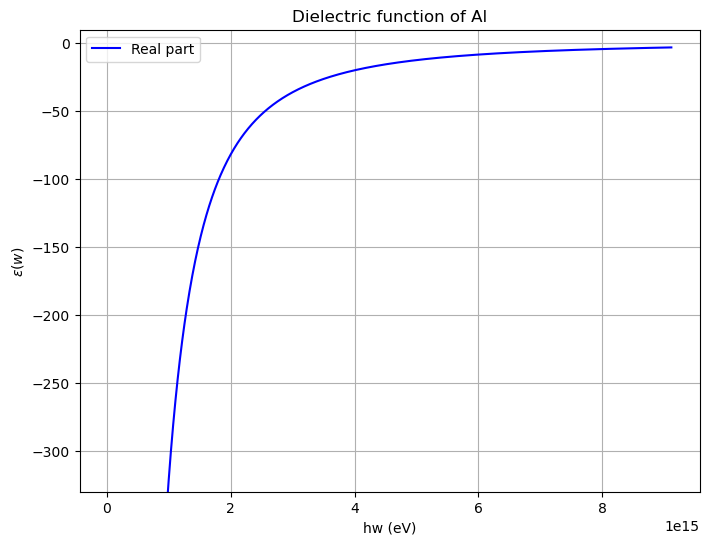

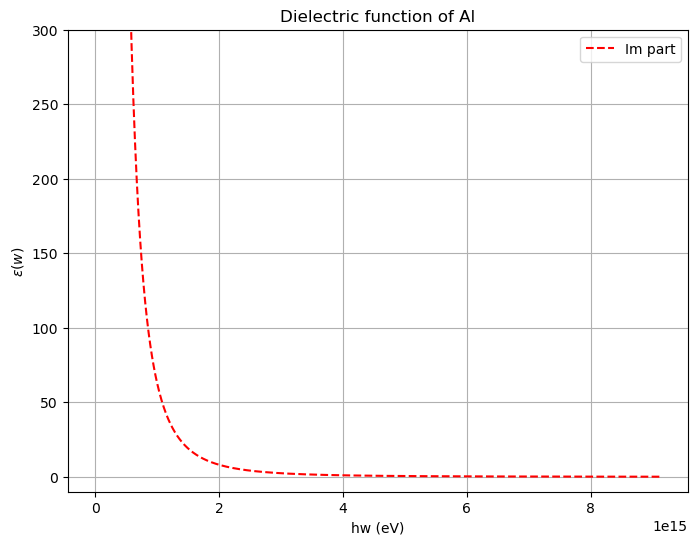

In [ ]:
#Drude model
# Range of values of w (frequency)
w_values = np.linspace(0.01*eV, 6*eV, 1000) 

# Calculate eps for med = 2
eps_values = np.array([get_eps(w, 2) for w in w_values])

eps_real = np.real(eps_values)
eps_imag = np.imag(eps_values)

# graph
plt.figure(figsize=(8, 6))
plt.plot(w_values, eps_real, label="Real part", color='blue')
plt.title('Dielectric function of Al')
plt.xlabel('hw (eV)')
plt.ylabel('$\epsilon(w)$')
plt.legend()
plt.ylim(-330, 10)

plt.grid(True)
plt.show()


plt.figure(figsize=(8, 6))
plt.plot(w_values, eps_imag, label="Im part", color='red', linestyle='--')

# Add title
plt.title('Dielectric function of Al')
plt.xlabel('hw (eV)')
plt.ylabel('$\epsilon(w)$')
plt.legend()
plt.ylim(-10, 300)

# show
plt.grid(True)
plt.show()

/var/folders/yh/cycxl0_j42bb7_1dhcyz1syh0000gn/T/ipykernel_62918/1919833100.py:40: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  Gxx_imag, error_imag = quad(lambda kp: np.imag(fxx(kp)), 0, kp_max, limit=maxi)
/var/folders/yh/cycxl0_j42bb7_1dhcyz1syh0000gn/T/ipykernel_62918/1919833100.py:43: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  Gzz_imag, error_imag = quad(lambda kp: np.imag(fzz(kp)), 0, kp_max, limit=maxi)


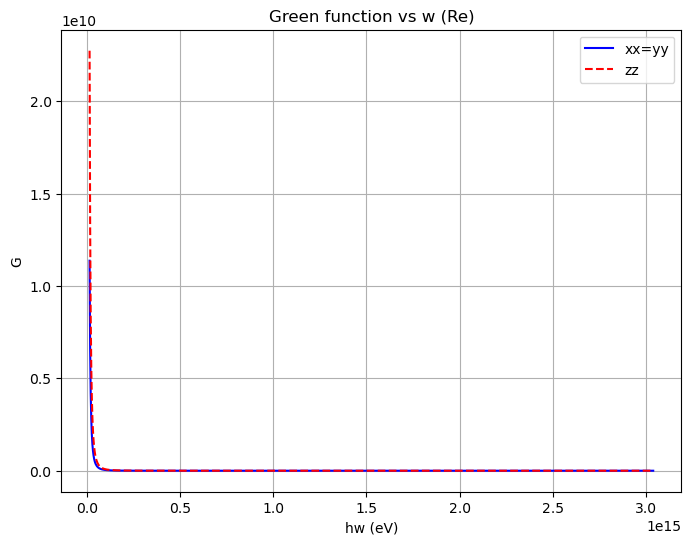

In [11]:
#Green function vs w
w_values = np.linspace(0.01*eV, 2*eV, 1000) 

# Calcular eps para med = 2
eps_values_xx = np.array([get_G(w, 20 * nm, 5 * nm, 10 / (5 * nm), 1000)[0] for w in w_values])
eps_values_zz = np.array([get_G(w, 20 * nm, 5 * nm, 10 / (5 * nm), 1000)[2] for w in w_values])

# Crear la gráfica
plt.figure(figsize=(8, 6))
plt.plot(w_values, eps_values_xx, label="xx=yy", color='blue')
plt.plot(w_values, eps_values_zz, label="zz", color='red', linestyle='--')
plt.title('Green function vs w (Re)')
plt.xlabel('hw (eV)')
plt.ylabel('G')
plt.legend()
#plt.ylim(1, 1)

plt.grid(True)
plt.show()